# Segunda Escuela Peruana de Computación Cuántica

## Una Introducción a los Algoritmos de Optimización Cuántica Aproximada (QAOA)
**Pedro Faria Albuquerque**
*Universidade Federal de Minas Gerais (UFMG)*

---

# Una Introducción a los Algoritmos de Optimización Cuántica Aproximada (QAOA)

## ¿Qué es QAOA?

El **Algoritmo de Optimización Cuántica Aproximada** (Quantum Approximate Optimization Algorithm) fue propuesto originalmente por Farhi et al. en 2014. Está diseñado para resolver problemas de optimización combinatoria.

* **Algoritmo Híbrido:** Utiliza una computadora cuántica para preparar estados y medir valores esperados, y un optimizador clásico para actualizar los parámetros.
    * $\rightarrow$ Esto lo hace altamente adecuado para dispositivos **NISQ** (Noisy Intermediate-Scale Quantum).
* **Objetivo:** Encuentra soluciones **aproximadas** a nuestro problema de optimización.
* **Aplicaciones:** Max-Cut, Problema del Viajante (Traveling Salesperson), aplicaciones financieras (Optimización de Portafolios), etc.


¿Qué vamos a hacer en esta charla?

* Entender cómo formular problemas de optimización combinatoria adecuados para computadoras cuánticas
* Justificar por qué las computadoras cuánticas son útiles para resolver estos problemas
* Implementar un ejemplo simple de QAOA

### Formulando el Problema: QUBO

Para utilizar QAOA, debemos escrebir nuestro problema como un **Problema de Optimización Binaria**. Vamos hacer hecho utilizando el *framweork* **QUBO** (Quadratic Unconstrained Binary Optimization).

El objetivo es minimizar la función de costo $C(x)$:

$$
C(x) = \min_{x \in \{0,1\}^n} x^T Q x = \sum_{i,j}^n Q_{ij}x_i x_j
$$

Donde:
* $x \in \{0,1\}^n$ es un vector binario.
* $Q$ es una matriz simétrica ($Q_{ij} = Q_{ji}$) que define los pesos y las interacciones.

### El Cambio de Variables

Las computadoras cuánticas miden en la base computacional, donde las mediciones del operador Pauli-$Z$ producen autovalores de $+1$ o $-1$.
* $Z|0\rangle = +1|0\rangle$
* $Z|1\rangle = -1|1\rangle$

Nuestra variable QUBO $x \in \{0,1\}$ no coincide con esto naturalmente. Por esta razón mapeamos nuestras variables binarias a variables de spín $z \in \{+1, -1\}$.

**El Mapeo:**
$$
x_i = \frac{1 - z_i}{2} \implies \begin{cases} \text{si } z_i = +1 \rightarrow x_i = 0 \\ \text{si } z_i = -1 \rightarrow x_i = 1 \end{cases}
$$

### Construcción del Hamiltoniano de Costo ($H_C$)

Al sustituir $x_i = \frac{1 - z_i}{2}$ en nuestra función de costo original, transformamos el problema de QUBO al **Modelo de Ising**.

$$
C(z) = \sum_{i<j} Q'_{ij} z_i z_j + \sum_i L'_i z_i + \text{const}
$$

*(Nota: Los coeficientes $Q'_{ij}$ y $L'_i$ se derivan directamente de la matriz $Q$.)*

---

#### Implementación en Computadoras Cuánticas

Para implementar esto en una Computadora Cuántica, cambiamos las variables $z_i$ a operadores cuánticos.

$z_i \rightarrow Z_i$

Donde $Z_i$ es la matriz Pauli-$Z$ actuando sobre el $i$-ésimo qubit. En el sistema completo de múltiples qubits, esto implica aplicar el operador Identidad ($I$) a todos los demás qubits.

**Definición Matemática:**
$$
Z_i = I_0 \otimes I_1 \otimes \dots \otimes \underbrace{Z}_{i\text{-ésima posición}} \otimes \dots \otimes I_n
$$

En consecuencia, el término $Z_i Z_j$ representa un producto tensorial donde se aplica $Z$ en los índices $i$ y $j$, e $I$ en todos los demás lugares.

**El Hamiltoniano de Costo Final:**
$$
H_C = \sum_{i<j} Q'_{ij} (Z_i \otimes Z_j) + \sum_i L'_i Z_i
$$

El estado fundamental (estado de menor energía) de este Hamiltoniano corresponde a la solución óptima de nuestro problema original.

### Implementación del Hamiltoniano de Costo en un Circuito

Ahora que tenemos el Hamiltoniano de costo $H_C$, necesitamos una manera de implementarlo en una computadora cuántica. En mecánica cuántica, los Hamiltonianos generan evolución temporal de acuerdo con la ecuación de Schrödinger.

Para "codificar" nuestro problema en el estado cuántico, definimos un operador de evolución temporal $U_C$ que evoluciona el sistema por un tiempo (parámetro) específico $\gamma$.

$$
U_C(\gamma) = e^{-i\gamma H_C}
$$

Donde $\gamma$ es un parámetro variacional que optimizaremos más tarde.

---

#### Descomposición en Compuertas Lógicas

Dado que nuestro Hamiltoniano $H_C$ consiste solo en términos de Pauli-$Z$, todos los términos en la suma conmutan entre sí ($[Z_i, Z_j] = 0$). Esto nos permite usar las reglas de exponenciación de matrices para dividir la exponencial de la suma en un producto de exponenciales:

$$
e^{-i \gamma (\sum Q'_{ij} Z_i Z_j + \sum L'_i Z_i)} = \prod_{i<j} e^{-i \gamma Q'_{ij} Z_i Z_j} \times \prod_i e^{-i \gamma L'_i Z_i}
$$

Esto significa que podemos implementar nuestro Hamiltoniano complejo aplicando una secuencia de compuertas simples para cada término.


El término linear $e^{-i \gamma L'_i Z_i}$ es simplemente una rotación alrededor del eje Z. Dado que $R_Z(\theta) = e^{-i \frac{\theta}{2} Z}$, establecemos $\theta = 2\gamma L'_i$:

$$
e^{-i \gamma L'_i Z_i} \rightarrow R_Z(2\gamma L'_i)
$$

El término de interacción $e^{-i \gamma Q'_{ij} Z_i Z_j}$ requiere compuertas de entrelazamiento. Se implementa usando la identidad "CNOT":

$$
e^{-i \gamma Q'_{ij} Z_i \otimes Z_j} \rightarrow CNOT_{ij} \cdot R_Z(2\gamma Q'_{ij}) \cdot CNOT_{ij}
$$

#### Visualización del Circuito

A continuación se muestra la representación en circuito de estos términos.
* La **parte izquierda** muestra la implementación del término de interacción ($Q'_{ij}$) entre dos qubits.
* La **parte derecha** muestra la implementación del término de campo local ($L'_i$).

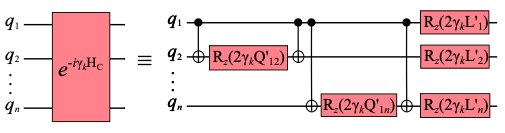

<div style="text-align: center; font-size: 0.8em; color: gray; margin-top: 10px; line-height: 1.4;">
    <em>Figure 1: Decomposition of Ising Hamiltonian terms into Quantum Gates.<br>
    Source: A. Canabarro et al., "Quantum Finance: um tutorial de computação quântica aplicada ao mercado financeiro",<br>
    Rev. Bras. Ensino Fís., vol. 44, e20220099 (2022). <br>
    <a href="https://doi.org/10.1590/1806-9126-RBEF-2022-0099" style="color: gray; text-decoration: none;">DOI: 10.1590/1806-9126-RBEF-2022-0099</a></em>
</div>

---
Hemos implementado con éxito nuestra función de costo como un circuito cuántico $U_C$. Sin embargo, simplemente aplicar este operador no garantiza que encontremos la solución.

Para entender **por qué** esta estructura nos ayuda a encontrar la solución óptima, necesitamos dar un paso atrás y observar la inspiración física de QAOA: **El Teorema Adiabático y la Computación Cuántica Adiabática.**

### Teorema Adiabático

Para entender cómo encontramos la solución, recurrimos al **Teorema Adiabático**. Dicho de manera simple:

> "Si un sistema cuántico comienza en el estado fundamental (mínima energía) de un Hamiltoniano, y ese Hamiltoniano cambia **lo suficientemente lento** a lo largo del tiempo, el sistema permanecerá en el estado fundamental del Hamiltoniano instantáneo."


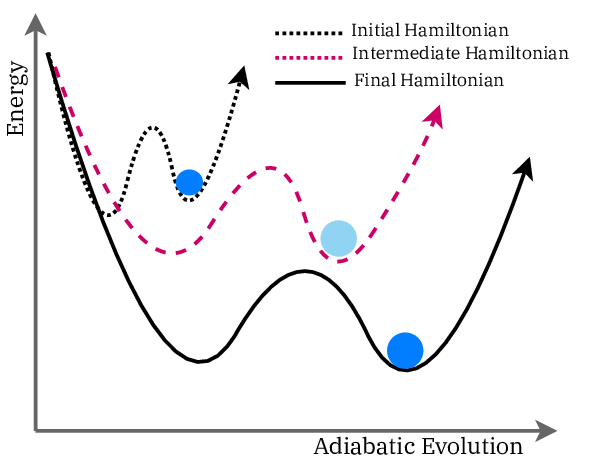


**La Estrategia para problemas de optimizácion:**
1.  Comenzar con un Hamiltoniano "Fácil" ($H_B$) donde conocemos el estado fundamental.
2.  Evolucionar lentamente el sistema hasta que el Hamiltoniano se convierta en nuestro Hamiltoniano del "Problema" ($H_C$).
3.  ¡Al final, deberíamos estar en el estado fundamental de $H_C$, lo cual corresponde a nuestra solución óptima!

### 1. El Hamiltoniano de Mezcla (Mixer Hamiltonian)

Necesitamos un punto de partida donde el estado fundamental sea fácil de preparar. En QAOA, llamamos a esto el **Hamiltoniano de Mezcla** ($H_B$). Típicamente lo definimos como la suma de operadores Pauli-$X$:

$$
H_B = \sum_i X_i
$$

Así que el operador unitario que codificará esto es:

$$
U_B = e^{i\beta H_B}
$$

Lo cual se puede escribir en términos de compuertas como:

$$
U_B = e^{i\beta_i X_i} \rightarrow R_X(2\beta_i)
$$


**El Estado Inicial:**
El estado fundamental de este Hamiltoniano es simplemente el estado "plus" para cada qubit. Esto es físicamente fácil de crear usando compuertas Hadamard en todos los qubits inicializados en $|0\rangle$:

$$
|\psi_{init}\rangle = |+\rangle^{\otimes n} = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} |x\rangle
$$

*Nota: Esta es una superposición uniforme de todas las soluciones posibles*

### Implementación del Hamiltoniano de Mezcla

Tal como hicimos con el Hamiltoniano de Costo, definimos el operador unitario para el Hamiltoniano de Mezcla $H_B$. Este operador genera transiciones entre diferentes cadenas de bits, permitiéndonos explorar el espacio de soluciones.

$$
U_B(\beta) = e^{-i\beta H_B} = e^{-i\beta \sum_i X_i}
$$

Dado que los operadores Pauli-$X$ en diferentes qubits conmutan (actúan sobre espacios diferentes), podemos aplicar esta evolución independientemente a cada qubit.

**Descomposición en Compuertas:**
Mapeamos esta exponencial directamente a la compuerta de Rotación-X ($R_X$), usando la definición $R_X(\theta) = e^{-i\frac{\theta}{2}X}$.

$$
U_B = \prod_i e^{-i\beta X_i} \longrightarrow \bigotimes_i R_X(2\beta)
$$

Esto resulta en una capa de circuito muy simple: una columna de compuertas $R_X$ aplicadas a cada qubit, todas con el mismo ángulo $2\beta$.

---

#### Visualización del Circuito

A continuación se muestra la representación en circuito de la capa de Mezcla. Muestra la aplicación de rotaciones de un solo qubit para evolucionar el estado.
---

#### Circuit Visualization

Below is the circuit representation of the Mixer layer. It shows the application of single-qubit rotations to evolve the state.
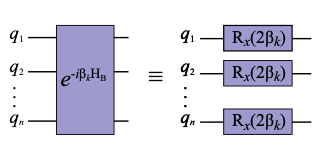

<div style="text-align: center; font-size: 0.8em; color: gray; margin-top: 10px; line-height: 1.4;">
    <em>Figure 2: Implementation of the Mixer Hamiltonian using single-qubit gates.<br>
    Source: A. Canabarro et al., "Quantum Finance: um tutorial de computação quântica aplicada ao mercado financeiro",<br>
    Rev. Bras. Ensino Fís., vol. 44, e20220099 (2022). <br>
    <a href="https://doi.org/10.1590/1806-9126-RBEF-2022-0099" style="color: gray; text-decoration: none;">DOI: 10.1590/1806-9126-RBEF-2022-0099</a></em>
</div>

2. Evolución Discreta

El teorema adiabático implica una transformación continua entre el hamiltoniano inicial y el final. Sin embargo, las computadoras cuánticas basadas en compuertas operan con compuertas lógicas discretas.

Para simular esta evolución continua, usamos la **Descomposición de Suzuki-Trotter**.

$$
e^{A+B} = \lim_{p \rightarrow \infty} (e^{A/p}e^{B/p})^p
$$

**La Intuición:**

En lugar de un cambio continuo, aplicamos los operadores en **capas** (o pasos):

$$
U_{QAOA} \approx \prod_{p=1}^{P} e^{-i\beta_p H_B} e^{-i\gamma_p H_C}
$$

Donde:
* $e^{-i\gamma H_C}$ es la **Capa del Problema** (o Capa de Separación de Fase).
* $e^{-i\beta H_B}$ es la **Capa de Mezcla** (Mixing).
* $p$ es la **Profundidad** (el número de capas). Cuanto mayor sea $p$, mejor será la aproximación al camino adiabático.

---

**La estructura del Circuito QAOA:**
Esto nos deja con un circuito que parece un sándwich de operadores alternados:

1.  **Inicializar:** $|+\rangle^{\otimes n}$
2.  **Aplicar Costo:** $U(H_C, \gamma_1)$
3.  **Aplicar Mezcla:** $U(H_B, \beta_1)$
4.  **Repetir** $p$ veces...


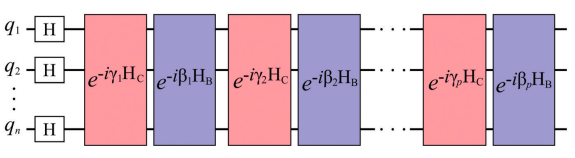
<div style="text-align: center; font-size: 0.8em; color: gray; margin-top: 10px; line-height: 1.4;">
    <em>Figure 2: Implementation of the Mixer Hamiltonian using single-qubit gates.<br>
    Source: A. Canabarro et al., "Quantum Finance: um tutorial de computação quântica aplicada ao mercado financeiro",<br>
    Rev. Bras. Ensino Fís., vol. 44, e20220099 (2022). <br>
    <a href="https://doi.org/10.1590/1806-9126-RBEF-2022-0099" style="color: gray; text-decoration: none;">DOI: 10.1590/1806-9126-RBEF-2022-0099</a></em>
</div>

### 3. Optimización:

Ahora tenemos un circuito cuántico parametrizado que prepara un estado $|\psi(\beta, \gamma)\rangle$. Pero, ¿cómo encontramos los parámetros $\beta$ y $\gamma$ que nos dan la solución óptima?

Usamos una **estrategia Híbrida Cuántica-Clásica**:



1.  **Procesador Cuántico:** Ejecuta el circuito con los parámetros actuales $(\beta, \gamma)$ y mide el valor esperado del Hamiltoniano de costo: $\langle \psi | H_C | \psi \rangle$.
2.  **Computadora Clásica:** Toma este valor como la "energía" y usa un algoritmo de optimización clásico (como COBYLA o SPSA) para sugerir nuevos parámetros.
3.  **Repetir:** Repetimos este proceso hasta que la energía se minimice.

Una vez optimizado, el estado final $|\psi(\beta_{opt}, \gamma_{opt})\rangle$ se mide para revelar la cadena de bits de solución aproximada $z$.

Entonces podemos hacer un resumo completo de QAOA:

1. Definir un QUBO que codifique su problema de optimización combinatoria;
2. Definir un Hamiltoniano de costo $H_C$ a partir del QUBO, tal que su estado fundamental codifique la solución al problema de optimización.
3. Definir un Hamiltoniano de mezcla $H_M$.
4. Definir los circuitos para las capas de costo $e^{-i\gamma H_C}$ y de mezcla $e^{-i \beta H_B}$.
5. Elegir un parámetro $p > 1$ y construir el circuito
$$
U(\gamma, \beta) =  e^{-i\gamma_p H_C}e^{-i \beta_p H_B} \cdots e^{-i\gamma_1 H_C}e^{-i \beta_1 H_B}
$$
que consiste en la aplicación repetida de las capas de costo y mezcla.
6. Preparar los qubits en un estado de superposición lineal $|+\rangle^{\otimes n}$ y aplicar el circuito $U(\gamma, \beta)$.
7. Medir el valor esperado del Hamiltoniano de costo: $\langle \psi | H_C | \psi \rangle$ y usar técnicas clásicas para optimizar el parámetro.
8. Medir el estado $|\psi(\beta_{opt}, \gamma_{opt})\rangle$ para revelar la cadena de bits de solución aproximada $z$.

### Un ejemplo simple:

Para verificar nuestra comprensión, resolveremos un problema simple donde comenzamos con un problema QUBO, lo convertimos en un Hamiltoniano de costo y construimos las capas de QAOA y el proceso de optimización. Al final veremos que QAOA proporciona una solución a nuestro problema. Por supuesto, este no es un problema NP-Hard ni nada por el estilo, pero sirve para ilustrar lo que hemos estudiado aquí.


### 1. Simple Binary Optimization Problem

$$
\mathbf{Q} = \begin{pmatrix}
      1 & 0 & 2 & 3 \\
      0 & 5 & -5 & 0 \\
      2 & -5 & 3 & 0 \\
      3 & 0 & 0 & 1
    \end{pmatrix}
$$

$$
\mathbf{x} = \begin{pmatrix}
                x_1 \\
                x_2 \\
                x_3 \\
                x_4 
               \end{pmatrix}
$$

$$
C(x) = \min_{x \in \{0,1\}^n} \mathbf{x}^T\mathbf{Q}\mathbf{x}
$$

In [14]:
import dimod
from pennylane import numpy as np
import matplotlib.pyplot as plt


# Define the Cost Matrix
Q = np.array([[1,0,2,3],
             [0,5,-5,0],
             [2,-5,3,0],
             [3,0,0,1]])
(n, n) = Q.shape

# Create the Binary Quadratic Model
bqm = dimod.BinaryQuadraticModel('BINARY')

for i in range(n):
    bqm.add_linear(i, Q[i, i])      # Add linear terms (Diagonal)
    for j in range(i + 1, n):
        bqm.add_quadratic(i, j, 2*Q[i, j]) # Add quadratic terms (Off-diagonal)

# Solve exactly (Brute Force)
sampler_exact = dimod.ExactSolver()
sampleset_exact = sampler_exact.sample(bqm)
best_sample = sampleset_exact.first.sample

print("The Classical Solution is:", best_sample)

The Classical Solution is: {0: np.int8(0), 1: np.int8(1), 2: np.int8(1), 3: np.int8(0)}


The best classic solution found by the solver is: 0110

In [16]:
print('The classical solution in decimal numbers is :',int('0110',2))

The classical solution in decimal numbers is : 6


In [24]:
# Let's convert the QUBO to Ising Model
Ll, Ql, offset = bqm.to_ising()

print("Linear Coefficients (L'):", Ll)
print("Coupling Coefficients (Q'):", Ql)
print("Energy Offset:", offset)

Linear Coefficients (L'): {0: np.float64(3.0), 1: np.float64(0.0), 2: np.float64(0.0), 3: np.float64(2.0)}
Coupling Coefficients (Q'): {(1, 0): np.float64(0.0), (2, 0): np.float64(1.0), (2, 1): np.float64(-2.5), (3, 0): np.float64(1.5), (3, 1): np.float64(0.0), (3, 2): np.float64(0.0)}
Energy Offset: 5.0


In [25]:
### import pennylane
import pennylane as qml
from pennylane import qaoa

In [52]:
coeffs = []
observables = []

# 1. Process Linear Terms (L'_i * Z_i)
for i, coeff in Ll.items():
    coeffs.append(-coeff)
    observables.append(qml.PauliZ(i))

# 2. Process Quadratic Terms (Q'_ij * Z_i @ Z_j)
for (i, j), coeff in Ql.items():
    coeffs.append(coeff)
    # The '@' symbol represents the Tensor Product (Interaction)
    observables.append(qml.PauliZ(i) @ qml.PauliZ(j))

### For the mixer Hamiltonian:
mixer = [qml.PauliX(i) for i in range(4)]
mixer_coef = np.ones(4)
# 3. Create the PennyLane Hamiltonian
H_cost = qml.Hamiltonian(coeffs, observables)
H_mixer = qml.Hamiltonian(mixer_coef, mixer)
print("Cost Hamiltonian constructed:")
print(H_cost)
print("Mixer Hamiltonian constructed:")
print(H_mixer)

Cost Hamiltonian constructed:
-3.0 * Z(0) + -0.0 * Z(1) + -0.0 * Z(2) + -2.0 * Z(3) + 0.0 * (Z(1) @ Z(0)) + 1.0 * (Z(2) @ Z(0)) + -2.5 * (Z(2) @ Z(1)) + 1.5 * (Z(3) @ Z(0)) + 0.0 * (Z(3) @ Z(1)) + 0.0 * (Z(3) @ Z(2))
Mixer Hamiltonian constructed:
1.0 * X(0) + 1.0 * X(1) + 1.0 * X(2) + 1.0 * X(3)


In [53]:
### Create QAOA layer
def qaoa_layer(gamma, beta):
    # Apply Cost Hamiltonian evolution
    qml.ApproxTimeEvolution(H_cost, gamma, 1)
    
    # Apply Mixer Hamiltonian evolution
    qml.ApproxTimeEvolution(H_mixer, beta, 1)

In [54]:
dev = qml.device('default.qubit', wires = 4)
@qml.qnode(dev)
def circuit(params, layers=1):
    # Start in superposition:
    for i in range(n):
        qml.Hadamard(wires=i)
    
    # Apply QAOA layer
    # param[0] = gamma and param[1] = betta
    for p in range(layers):
        qaoa_layer(params[0][p], params[1][p])
        
    # Return expectation value    
    return qml.expval(H_cost)

In [67]:
# Define optimizer
opt = qml.AdamOptimizer(stepsize=0.01)

# Iterations and layers
steps =80
layers = 1

# Define a initial set of parameters
# We kind of know that they are best so it is a little bit of cheating
#params = np.array([[1.  , 1.],[1., 1.]], requires_grad = True)
params = np.random.uniform(0, 0.5, (2, layers), requires_grad=True)
print(f"Initial Energy: {circuit(params, layers=layers):.4f}")

# Runs optimization
for i in range(steps):
    params = opt.step(lambda p: circuit(p, layers=layers), params)
    
    if (i + 1) % 10 == 0:
        current_energy = circuit(params, layers=layers)
        print(f"Step {i+1}: Energy = {current_energy:.4f}")

print("\nOptimized Parameters:\n", params)

Initial Energy: 3.6690
Step 10: Energy = 1.4804
Step 20: Energy = 0.1505
Step 30: Energy = -0.0030
Step 40: Energy = 0.0137
Step 50: Energy = -0.1155
Step 60: Energy = -0.6035
Step 70: Energy = -2.2294
Step 80: Energy = -3.8858

Optimized Parameters:
 [[ 0.18975293]
 [-0.28698544]]


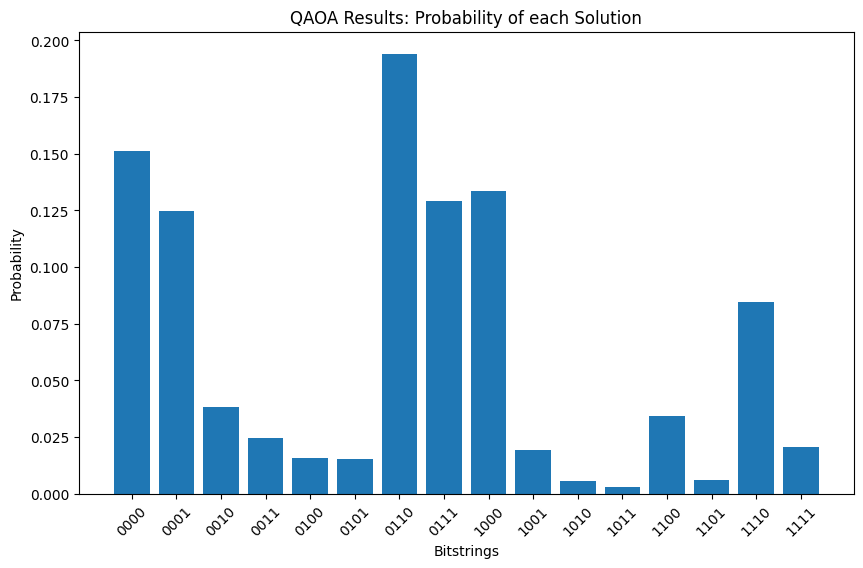

Most likely solution: 0110


In [68]:
@qml.qnode(dev)


def probability_circuit(params, layers=1):
    # Same circuit structure
    for i in range(n):
        qml.Hadamard(wires=i)
    for p in range(layers):
        qaoa_layer(params[0][p], params[1][p])
        
    # returns the probabilities 
    return qml.probs(wires=range(n))

# Get the probabilities using the OPTIMIZED parameters
probs = probability_circuit(params, layers=layers)

# Visualize the results
import matplotlib.pyplot as plt

# Generate binary labels ['0000', '0001', ...]
bitstrings = [f"{x:0{n}b}" for x in range(2**n)]

plt.figure(figsize=(10, 6))
plt.bar(bitstrings, probs)
plt.xticks(rotation=45)
plt.xlabel("Bitstrings")
plt.ylabel("Probability")
plt.title("QAOA Results: Probability of each Solution")
plt.show()

most_likely_index = np.argmax(probs)
print(f"Most likely solution: {bitstrings[most_likely_index]}")

Hemos encontrado la solución a nuestro problema. Observen, sin embargo, que la probabilidad en sí misma no es muy alta. Como hemos discutido en la parte teórica de la charla, uno de los ingredientes clave para mejorar el QAOA es un aumento en las capas $p$ de nuestro circuito.

Initial Energy: 3.6811
Step 10: Energy = 0.4622
Step 20: Energy = -0.1408
Step 30: Energy = -0.6928
Step 40: Energy = -1.7710
Step 50: Energy = -2.7880
Step 60: Energy = -3.2865
Step 70: Energy = -3.9935
Step 80: Energy = -4.4969

Optimized Parameters:
 [[ 0.20322988  0.51087022]
 [-0.3927353   0.00248397]]


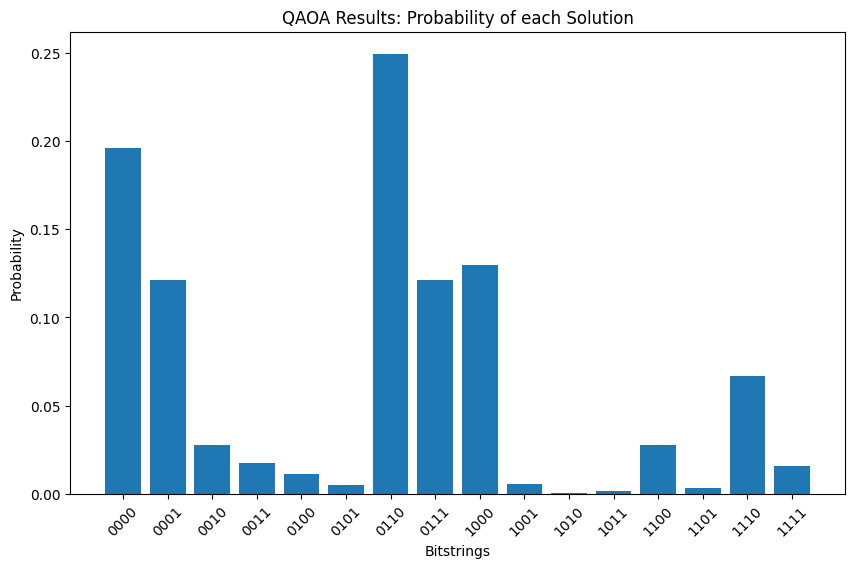

Most likely solution: 0110


In [70]:
# Define optimizer
opt = qml.AdamOptimizer(stepsize=0.01)

# Iterations and layers
steps =80
layers = 2

# Define a initial set of parameters
# We kind of know that they are best so it is a little bit of cheating
#params = np.array([[1.  , 1.],[1., 1.]], requires_grad = True)
params = np.random.uniform(0, 0.5, (2, layers), requires_grad=True)
print(f"Initial Energy: {circuit(params, layers=layers):.4f}")

# Runs optimization
for i in range(steps):
    params = opt.step(lambda p: circuit(p, layers=layers), params)
    
    if (i + 1) % 10 == 0:
        current_energy = circuit(params, layers=layers)
        print(f"Step {i+1}: Energy = {current_energy:.4f}")

print("\nOptimized Parameters:\n", params)


@qml.qnode(dev)


def probability_circuit(params, layers=1):
    # Same circuit structure
    for i in range(n):
        qml.Hadamard(wires=i)
    for p in range(layers):
        qaoa_layer(params[0][p], params[1][p])
        
    # returns the probabilities 
    return qml.probs(wires=range(n))

# Get the probabilities using the OPTIMIZED parameters
probs = probability_circuit(params, layers=layers)

# Visualize the results
import matplotlib.pyplot as plt

# Generate binary labels ['0000', '0001', ...]
bitstrings = [f"{x:0{n}b}" for x in range(2**n)]

plt.figure(figsize=(10, 6))
plt.bar(bitstrings, probs)
plt.xticks(rotation=45)
plt.xlabel("Bitstrings")
plt.ylabel("Probability")
plt.title("QAOA Results: Probability of each Solution")
plt.show()

most_likely_index = np.argmax(probs)
print(f"Most likely solution: {bitstrings[most_likely_index]}")

Initial Energy: -0.7041
Step 10: Energy = -2.7295
Step 20: Energy = -3.3784
Step 30: Energy = -4.2112
Step 40: Energy = -4.8498
Step 50: Energy = -5.4585
Step 60: Energy = -5.6795
Step 70: Energy = -5.6942
Step 80: Energy = -5.7102

Optimized Parameters:
 [[ 0.24584106  0.41062499  0.00212757  0.23964992  0.5801087   0.40696698]
 [ 0.94136677  0.84153124  0.5425107  -0.14051191 -0.00625541  0.62456517]]


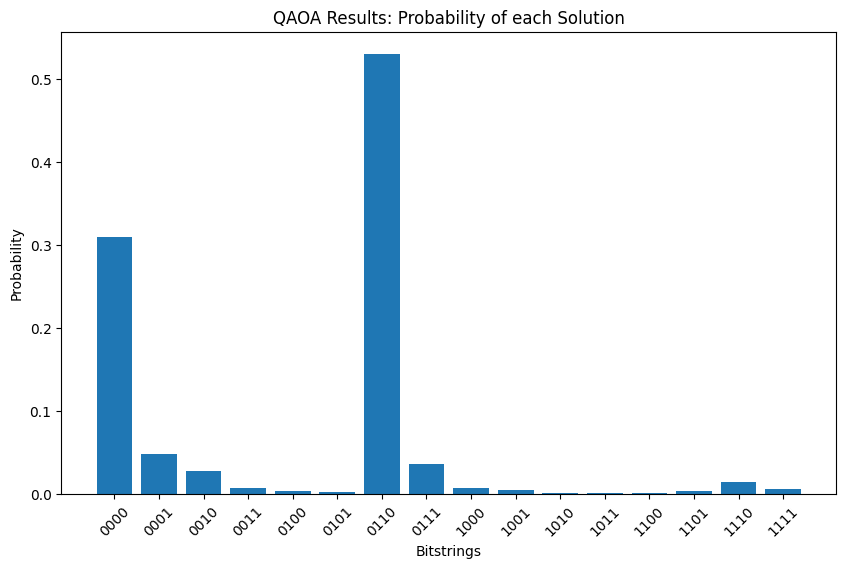

Most likely solution: 0110


In [72]:
# Define optimizer
opt = qml.AdamOptimizer(stepsize=0.01)

# Iterations and layers
steps =80
layers = 6

# Define a initial set of parameters
# We kind of know that they are best so it is a little bit of cheating
#params = np.array([[1.  , 1.],[1., 1.]], requires_grad = True)
params = np.random.uniform(0, 0.5, (2, layers), requires_grad=True)
print(f"Initial Energy: {circuit(params, layers=layers):.4f}")

# Runs optimization
for i in range(steps):
    params = opt.step(lambda p: circuit(p, layers=layers), params)
    
    if (i + 1) % 10 == 0:
        current_energy = circuit(params, layers=layers)
        print(f"Step {i+1}: Energy = {current_energy:.4f}")

print("\nOptimized Parameters:\n", params)


@qml.qnode(dev)


def probability_circuit(params, layers=1):
    # Same circuit structure
    for i in range(n):
        qml.Hadamard(wires=i)
    for p in range(layers):
        qaoa_layer(params[0][p], params[1][p])
        
    # returns the probabilities 
    return qml.probs(wires=range(n))

# Get the probabilities using the OPTIMIZED parameters
probs = probability_circuit(params, layers=layers)

# Visualize the results
import matplotlib.pyplot as plt

# Generate binary labels ['0000', '0001', ...]
bitstrings = [f"{x:0{n}b}" for x in range(2**n)]

plt.figure(figsize=(10, 6))
plt.bar(bitstrings, probs)
plt.xticks(rotation=45)
plt.xlabel("Bitstrings")
plt.ylabel("Probability")
plt.title("QAOA Results: Probability of each Solution")
plt.show()

most_likely_index = np.argmax(probs)
print(f"Most likely solution: {bitstrings[most_likely_index]}")

For 5 layers the results are a lot better! 

### Conclusiones:

En este notebook, estudiamos e implementamos un **Algoritmo de Optimización Cuántica Aproximada (QAOA)**:

1.  **Formulación del Problema:** Mapeamos un problema clásico de optimización binaria a una matriz **QUBO**.
2.  **Mapeo:** Tradujimos esta matriz a un Hamiltoniano Cuántico ($H_C$).
3.  **Construcción del Ansatz:** Construimos un circuito cuántico parametrizado usando capas alternadas de Hamiltonianos de Costo y de Mezcla, inspirados por el **Teorema Adiabático**.
4.  **Optimización Clásica:** Usamos el **Optimizador Adam** para encontrar los parámetros óptimos $(\gamma, \beta)$ que minimizan la energía.

### NISQ
Nuestros resultados demuestran que QAOA no da la respuesta con $100\%$ de probabilidad (como el algoritmo de Grover podría hacerlo en teoría). En cambio, **sesga la distribución de probabilidad**, haciendo que la solución correcta ($0110$) sea más probable que una elección aleatoria.

Existen muchas áreas de investigación en QAOA y Algoritmos Cuánticos Variacionales en general, por ejemplo:

1. Barren Plateaus;
2. Warm Start Optimization;
3. Equilibrio entre profundidad y ruido;


---
**¡Gracias!**